In [106]:
# !pip install ydata-profiling

In [107]:
import pandas as pd
import numpy as np
# from ydata_profiling import ProfileReport
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, accuracy_score
from mlxtend.plotting import plot_decision_regions
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report, confusion_matrix
%matplotlib inline

In [108]:
# @title loading data
df = pd.read_csv('Housing.csv')
df.shape,df.columns, df.dtypes

((75388, 24),
 Index(['SERIAL', 'DENSITY', 'OWNERSHP', 'OWNERSHPD', 'COSTELEC', 'COSTGAS',
        'COSTWATR', 'COSTFUEL', 'HHINCOME', 'VALUEH', 'ROOMS', 'BUILTYR2',
        'BEDROOMS', 'VEHICLES', 'NFAMS', 'NCOUPLES', 'PERNUM', 'PERWT', 'AGE',
        'MARST', 'BIRTHYR', 'EDUC', 'EDUCD', 'INCTOT'],
       dtype='object'),
 SERIAL         int64
 DENSITY      float64
 OWNERSHP       int64
 OWNERSHPD      int64
 COSTELEC       int64
 COSTGAS        int64
 COSTWATR       int64
 COSTFUEL       int64
 HHINCOME       int64
 VALUEH         int64
 ROOMS          int64
 BUILTYR2       int64
 BEDROOMS       int64
 VEHICLES       int64
 NFAMS          int64
 NCOUPLES       int64
 PERNUM         int64
 PERWT          int64
 AGE            int64
 MARST          int64
 BIRTHYR        int64
 EDUC           int64
 EDUCD          int64
 INCTOT         int64
 dtype: object)


Description of all varibles

| Column   | Description |
|----------|-------------|
| SERIAL   | Unique serial number of the record |
| DENSITY  | Population density of the area |
| OWNERSHP | Ownership status (1 for owner, 2 for renter) |
| OWNERSHPD| Detailed ownership status |
| COSTELEC | Monthly electricity cost |
| COSTGAS  | Monthly gas cost |
| COSTWATR | Monthly water cost |
| COSTFUEL | Monthly fuel cost |
| HHINCOME | Household income |
| VALUEH   | House value |
| ROOMS    | Number of rooms |
| BUILTYR2 | Year of construction |
| BEDROOMS | Number of bedrooms |
| VEHICLES | Number of vehicles |
| NFAMS    | Number of families in the household |
| NCOUPLES | Number of couples in the household |
| PERNUM   | Person number within household |
| PERWT    | indicates how many individuals in the U.S. population are statistically represented by a given person |
| AGE      | Age of respondent |
| MARST    | Marital status |
| BIRTHYR  | Year of birth |
| EDUC     | Education level |
| EDUCD    | Detailed education level |
| INCTOT   | Total pre-tax personal income or losses from all sources for the previous year.|


In [109]:
df.head()

,SERIAL,DENSITY,OWNERSHP,OWNERSHPD,COSTELEC,COSTGAS,COSTWATR,COSTFUEL,HHINCOME,VALUEH,...,NFAMS,NCOUPLES,PERNUM,PERWT,AGE,MARST,BIRTHYR,EDUC,EDUCD,INCTOT
0,1371772,920.0,1,13,9990,9993,360,9993,75000,700000,...,1,0,1,14,52,6,1969,7,71,75000
1,1371773,3640.9,2,22,1080,9993,1800,9993,13600,9999999,...,2,0,1,83,22,6,1999,10,101,5600
2,1371773,3640.9,2,22,1080,9993,1800,9993,13600,9999999,...,2,0,2,106,22,6,1999,7,71,8000
3,1371774,22.5,1,13,600,9993,9993,9993,7000,800000,...,1,0,1,33,62,4,1959,6,63,7000
4,1371775,3710.4,2,22,3600,9993,9997,9993,50500,9999999,...,1,0,1,297,50,3,1971,7,71,16000


In [110]:
# @title checking for duplicate values
serial_duplicates = df.duplicated(subset=['SERIAL']).sum()
print(f"Number of duplicates based on SERIAL: {serial_duplicates}")

Number of duplicates based on SERIAL: 44586


In [111]:
# @title missing values
df.isnull().sum()

SERIAL       0
DENSITY      0
OWNERSHP     0
OWNERSHPD    0
COSTELEC     0
COSTGAS      0
COSTWATR     0
COSTFUEL     0
HHINCOME     0
VALUEH       0
ROOMS        0
BUILTYR2     0
BEDROOMS     0
VEHICLES     0
NFAMS        0
NCOUPLES     0
PERNUM       0
PERWT        0
AGE          0
MARST        0
BIRTHYR      0
EDUC         0
EDUCD        0
INCTOT       0
dtype: int64

In [112]:
# @title
# ProfileReport(df)

We have more than 50% of the dataset with duplicates based on SERIAL column which is unique for each household. We have 0 null values in dataset which is a good sign, our dataset is clean!

**PERWT** variable is used when we want to do person analysis and it is not directly related to predicting home ownership, so having it is not required.

**BRTHYR** can be deleted as we have the AGE variable, this is repetitive.

**PERNUM** is not relevant since we are taking the eldest member from each family. But we will encode it like 1 for PERNUM > 1 and 0 for PERNUM ==1

**AGE**: We will take the maximum age from the rows as it is a good assumption that older individual in the household will be the owner or renter

**EDUCD** : Will delete this column from the data set since it's correlated with the EDUC

**INCTOT** : We will take mean for the INCTOT value

**HHINCOME** : removing this as it's highly correlated to avg income

In [113]:
df['PERNUM'].value_counts()

PERNUM
1     30802
2     22732
3     10921
4      6339
5      2670
6      1099
7       454
8       196
9        89
10       48
11       20
12       10
13        3
14        3
15        1
16        1
Name: count, dtype: int64

In [114]:
df['PERNUM_CODED'] = df['PERNUM'].apply(lambda x: 0 if x == 1 else 1)
df['PERNUM_CODED'].head()

0    0
1    0
2    1
3    0
4    0
Name: PERNUM_CODED, dtype: int64

In [115]:
df['PERNUM_CODED'].value_counts()

PERNUM_CODED
1    44586
0    30802
Name: count, dtype: int64

In [116]:
df['INCTOT'] = df.groupby('SERIAL')['INCTOT'].transform('mean')
df.shape

(75388, 25)

Let's make the dataset unique by keeping rows with unique SERIAL and highest aged individual

In [117]:
df_uni = df.sort_values(by=['SERIAL', 'AGE'], ascending=[True, False]).drop_duplicates(subset='SERIAL')
df_uni.shape

(30802, 25)

In [118]:
df_uni.reset_index(inplace = True)

In [119]:
df_uni.shape

(30802, 26)

In [120]:
# @title Dropping columns that are not important
df_uni = df_uni.drop(['PERWT', 'BIRTHYR','SERIAL', 'PERNUM', 'EDUCD', 'ROOMS', 'HHINCOME', 'VALUEH','OWNERSHPD','BUILTYR2'], axis=1)

In [121]:
df_uni.shape

(30802, 16)

In [122]:
df_uni[df_uni['AGE'] == 18].shape, df_uni[df_uni['AGE'] < 18].shape

((7, 16), (0, 16))

Our data doesn't have anyone aged less than 18, because younger people are not likely to own or rent a house

Let's make MARST a contunous variable

In [123]:
df_uni['MARST'].value_counts()

MARST
1    15780
6     5500
4     5429
5     2932
2      645
3      516
Name: count, dtype: int64

In [124]:
df_uni ['MARST'] = df_uni['MARST'].apply(lambda x: 0 if x == 6 else 1)

We can drop the original column now

In [125]:
# df_uni = df_uni.drop(['MARST'], axis=1)
# df_uni.shape

In [126]:
# @title Analysing COST columns
df_uni['COSTWATR'].value_counts()

COSTWATR
9993    4533
9997    4078
1200    1825
1500     903
1000     871
        ... 
620       20
690       19
3800      15
3900       9
3700       9
Name: count, Length: 133, dtype: int64

In [127]:
# @title
df_uni['COSTGAS'].value_counts()

COSTGAS
9993    15455
9992     3405
600      1209
360      1151
1200     1089
240       973
480       946
960       790
720       697
840       572
9997      519
120       472
1080      451
1800      431
2400      337
1440      315
1560      306
1320      262
7200      193
48        185
1680      167
3600      117
2160      112
1920      111
3000      111
2040      102
2280       54
2760       50
2640       40
2520       38
4200       34
2880       26
3360       19
3240       17
3480       14
3120       11
3720        7
4080        5
3840        5
3960        4
Name: count, dtype: int64

In [128]:
df_uni['COSTFUEL'].value_counts()

COSTFUEL
9993    27860
500       218
200       196
300       188
400       173
        ...  
290         1
740         1
410         1
270         1
670         1
Name: count, Length: 109, dtype: int64

In [129]:
# @title
df_uni['COSTELEC'].value_counts()

COSTELEC
1200    2603
960     1938
1800    1906
2400    1737
600     1653
720     1579
1440    1493
840     1480
1080    1433
1560    1312
480     1133
1320    1046
1680     972
2160     889
9997     845
360      797
3000     745
1920     742
3600     725
2040     697
2280     536
9993     412
2760     403
2640     382
240      356
2520     304
2880     258
4200     243
4800     241
3360     220
9990     208
3120     172
3240     167
3480     130
6000     120
3960     112
120       93
3840      84
5400      77
3720      69
4080      68
4560      60
4440      47
48        45
4320      41
4680      33
5040      28
5280      21
5160      21
6600      21
5640      19
5760      17
4920      16
5520      14
6480       9
5880       9
6120       9
6240       7
6360       5
Name: count, dtype: int64

All columns have values like 9993,9992,9997 that has high value count, except for COSTELEC where with low value counts for these numbers.  But it looks like these variables mean that the data is either missing or not correct, since the values are gonna affect the model, we'll recode these values to 0


In [130]:
# @title Transforming COST columns

df_uni['COSTWATR'] = df_uni['COSTWATR'].apply(lambda x: 0 if x > 9992 else x)
df_uni['COSTELEC'] = df_uni['COSTELEC'].apply(lambda x: 0 if x > 9992 else x)
df_uni['COSTGAS'] = df_uni['COSTGAS'].apply(lambda x: 0 if x > 9992 else x)
df_uni['COSTFUEL'] = df_uni['COSTFUEL'].apply(lambda x: 0 if x > 9992 else x)

In [131]:
df_uni.shape, df_uni.dtypes
# df_uni['OWNERSHP'].value_counts()

((30802, 16),
 index             int64
 DENSITY         float64
 OWNERSHP          int64
 COSTELEC          int64
 COSTGAS           int64
 COSTWATR          int64
 COSTFUEL          int64
 BEDROOMS          int64
 VEHICLES          int64
 NFAMS             int64
 NCOUPLES          int64
 AGE               int64
 MARST             int64
 EDUC              int64
 INCTOT          float64
 PERNUM_CODED      int64
 dtype: object)

In [132]:
# df_uni = pd.get_dummies(df_uni, columns=['EDUC'], prefix='EDUC', dtype=int)
# df_uni.shape

In [133]:
df['EDUC'].value_counts()

EDUC
6     18937
10    14272
11     8932
7      8616
8      6103
1      5618
0      4622
2      4319
5      1463
4      1259
3      1247
Name: count, dtype: int64

In [134]:
def categorize_educ(x):
    if x == 0 or x == 99:
        return 0
    elif x > 0 and x <= 6:
        return 1
    elif x > 6 and x <= 11:
        return 2
    else:
        return 0
# Apply the categorize_educ function to create the EDUC category column
df['EDUC'] = df_uni['EDUC'].apply(categorize_educ)

# Check the value counts of the EDUC category column
print(df['EDUC'].value_counts())


EDUC
2.0    20347
1.0    10007
0.0      448
Name: count, dtype: int64


In [135]:
# df_uni['BUILTYR2'].value_counts()

In [136]:
df_uni.head()

,index,DENSITY,OWNERSHP,COSTELEC,COSTGAS,COSTWATR,COSTFUEL,BEDROOMS,VEHICLES,NFAMS,NCOUPLES,AGE,MARST,EDUC,INCTOT,PERNUM_CODED
0,0,920.0,1,9990,0,360,0,4,2,1,0,52,0,7,75000.000000,0
1,1,3640.9,2,1080,0,1800,0,4,2,2,0,22,0,10,6800.000000,0
2,3,22.5,1,600,0,0,0,4,2,1,0,62,1,6,7000.000000,0
3,4,3710.4,2,3600,0,0,0,3,2,1,0,50,1,7,25250.000000,0
4,7,448.2,1,1560,3000,0,0,4,2,1,1,93,1,10,51766.666667,1


In [137]:
# @title Class imbalance, using stratify sampling
class_distribution = df_uni['OWNERSHP'].value_counts(normalize=True)

# Print the class distribution
print("Class Distribution:")
print(class_distribution)

Class Distribution:
OWNERSHP
1    0.707194
2    0.292806
Name: proportion, dtype: float64


In [138]:
sampled_df = df_uni.sample(n=10000, random_state=42)
sampled_df.shape

(10000, 16)

In [139]:
# @title Splitting dataset and scaling the data
from sklearn.preprocessing import StandardScaler
X = sampled_df.drop(['OWNERSHP'], axis=1)
y = sampled_df['OWNERSHP']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_train)
X_train = scaling.transform(X_train)
X_test = scaling.transform(X_test)

In [140]:
grid_params = {'C': [0.001,  0.1, 1,  10, 100]}
svcfit = SVC(kernel='linear',cache_size=1000,random_state = 1, max_iter = 1000)
tune = GridSearchCV(svcfit, grid_params ,cv=5)
tune.fit(X_train,y_train)
tune.best_params_,(1 - tune.best_score_) # # best C and cv error rate

({'C': 1}, 0.29800000000000004)

SVM is highly efficient but looks like the model is overfitting. Let's try Decision Tree Classififer and see if there's any column that's causing overfitting

In [141]:
# @title Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(criterion='entropy', max_depth=10)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.809

Feature ranking:
1. Feature 'BEDROOMS' (0.330914)
2. Feature 'AGE' (0.156908)
3. Feature 'COSTWATR' (0.099993)
4. Feature 'INCTOT' (0.074295)
5. Feature 'COSTELEC' (0.066339)
6. Feature 'DENSITY' (0.064927)
7. Feature 'index' (0.049052)
8. Feature 'COSTGAS' (0.042025)
9. Feature 'EDUC' (0.023538)
10. Feature 'VEHICLES' (0.022211)
11. Feature 'NFAMS' (0.020646)
12. Feature 'COSTFUEL' (0.017108)
13. Feature 'MARST' (0.016572)
14. Feature 'NCOUPLES' (0.010700)
15. Feature 'PERNUM_CODED' (0.004772)


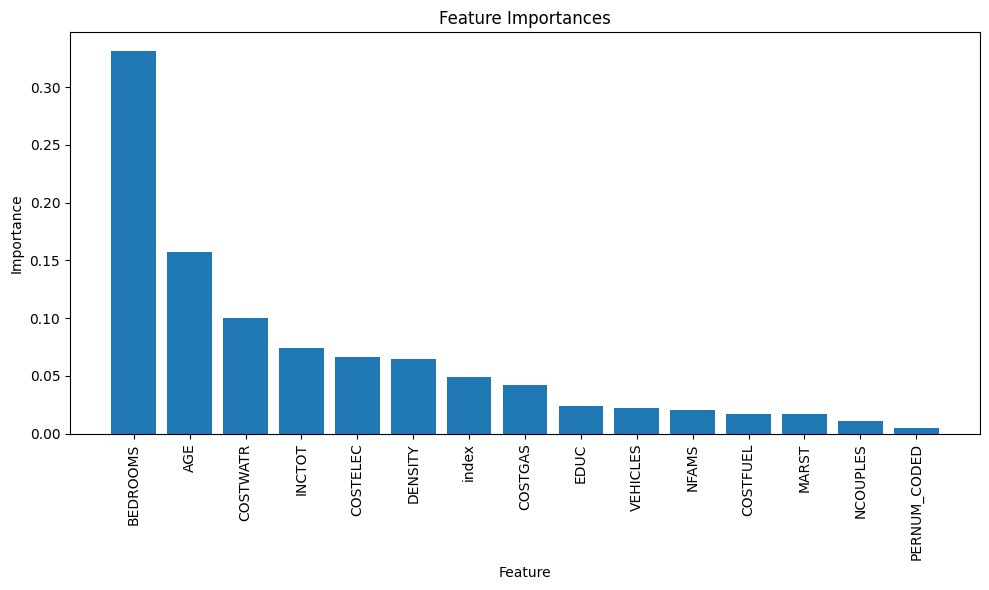

In [142]:
# @title feature importances
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort feature importances in descending order
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. Feature '%s' (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

VALUEH is the column that caused overfitting, let's not use it in our models.

In [143]:
# @title Splitting dataset and scaling the data without VALUEH
# df_uni = df_uni.drop(['VALUEH'], axis=1)

from sklearn.preprocessing import StandardScaler
X = sampled_df.drop(['OWNERSHP'], axis=1)
y = sampled_df['OWNERSHP']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_train)
X_train = scaling.transform(X_train)
X_test = scaling.transform(X_test)

In [144]:
grid_params = {'C': [0.001,  0.1, 1,  10, 100]}
svcfit = SVC(kernel='linear',cache_size=10000,random_state = 1, max_iter = 20000)
tune = GridSearchCV(svcfit, grid_params ,cv=5)
tune.fit(X_train,y_train)
print('Best Parameters: ',tune.best_params_)
print('Lowest cross-validation error rate: {:.2f}%'.format(1 - tune.best_score_))

Best Parameters:  {'C': 10}
Lowest cross-validation error rate: 0.16%


In [145]:
best_svc = tune.best_estimator_

# Get the coefficients from the best model
coefficients = best_svc.coef_[0]

# Rank the features by the absolute value of their coefficients
feature_importance = np.abs(coefficients)

# Get the indices of the features, sorted by importance
sorted_indices = np.argsort(feature_importance)[::-1]

# Print out the ranked features
print("Feature ranking:")
for idx in sorted_indices:
    print(f"Feature {idx}, Coefficient: {coefficients[idx]}")

Feature ranking:
Feature 6, Coefficient: -2.4401393666857345
Feature 8, Coefficient: 2.0009077892301086
Feature 4, Coefficient: -1.0978772825282306
Feature 10, Coefficient: -1.0410002718281355
Feature 2, Coefficient: -0.8580817070340387
Feature 5, Coefficient: -0.8271943675704705
Feature 9, Coefficient: -0.5583389225579722
Feature 12, Coefficient: -0.5482499402379695
Feature 1, Coefficient: 0.3810677043161732
Feature 13, Coefficient: 0.2736896558892461
Feature 3, Coefficient: -0.17556460433500476
Feature 7, Coefficient: 0.13570037140660318
Feature 11, Coefficient: -0.08646238430658215
Feature 0, Coefficient: 0.05084770255204507
Feature 14, Coefficient: 0.016710572324523554


In [146]:
y_pred = tune.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.85      0.92      0.89      2119
           2       0.77      0.62      0.69       881

    accuracy                           0.83      3000
   macro avg       0.81      0.77      0.79      3000
weighted avg       0.83      0.83      0.83      3000



**Top 5 features**

BEDROOMS	,  NFAMS, COSTWATR, AGE, COSTELEC

In [147]:
#sorting top features using permuration importance

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.inspection import permutation_importance

k = 15

selector = SelectKBest(f_classif, k=k)
selector.fit(X_train, y_train)
X_train_new = selector.transform(X_train)
X_test_new = selector.transform(X_test)

svc_linear = SVC(kernel='linear', C=0.1, cache_size=10000, random_state=1, max_iter=20000)
svc_linear.fit(X_train, y_train)

result = permutation_importance(svc_linear, X_test_new, y_test, n_repeats=5, random_state=1)
importance_df = pd.DataFrame({'feature': X.columns[selector.get_support()], 'importance': result.importances_mean})
importance_df = importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)
importance_df

,feature,importance
0,BEDROOMS,0.093133
1,AGE,0.036867
2,COSTWATR,0.009733
3,EDUC,0.006467
4,DENSITY,0.004800
5,COSTELEC,0.004200
6,INCTOT,0.002933
7,NFAMS,0.001933
8,COSTFUEL,0.001600
9,VEHICLES,0.001200


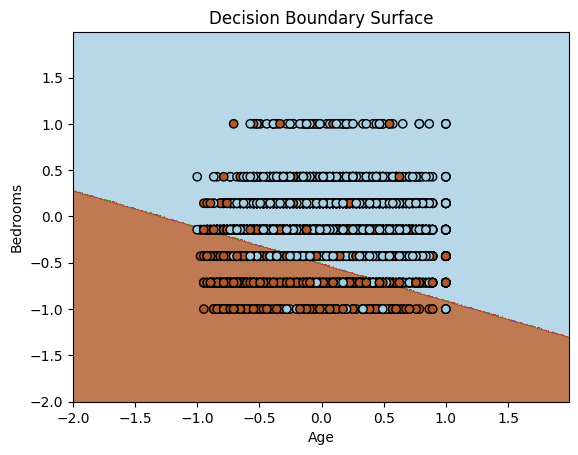

In [148]:
imp_df = sampled_df[[ 'AGE', 'BEDROOMS','OWNERSHP']]

X = imp_df.drop(['OWNERSHP'], axis=1)
y = imp_df['OWNERSHP']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_train)
X_train = scaling.transform(X_train)
X_test = scaling.transform(X_test)

svc_ = SVC(kernel='linear', C=0.1, cache_size=10000, random_state=1, max_iter=20000)
svc_.fit(X_train, y_train)  # Update to use features 6 and 8

class_labels = ['Class 0', 'Class 1']
# define a grid of points
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
Z = svc_.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# plot the decision boundary surface
# plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Paired, edgecolors='k')
plt.xlabel('Age')
plt.ylabel('Bedrooms')
# plt.legend(class_labels)
plt.title('Decision Boundary Surface')
plt.show()

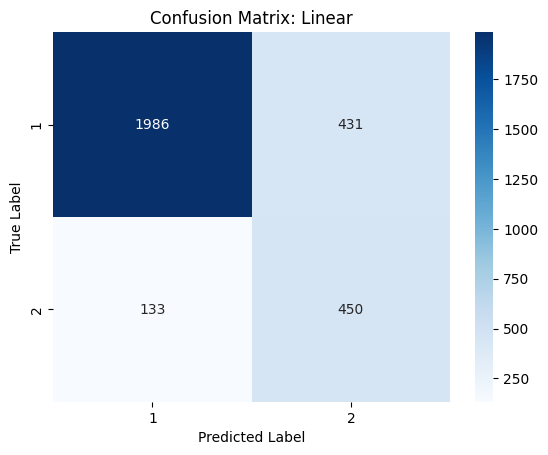

In [149]:
y_pred = svc_.predict(X_test)

# create confusion matrix
conf_matrix = pd.crosstab(index=y_pred, columns=y_test, rownames=[''])

# create a heatmap of the confusion matrix
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d")

# add labels to the plot
plt.title("Confusion Matrix: Linear")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [150]:
print('Test Error',np.mean(y_pred != y_test))
print('Test Accuracy',np.mean(y_pred == y_test))

Test Error 0.188
Test Accuracy 0.812


In [151]:
# @title Radial Kernel
grid_params = {'C': [0.1,1,10,100],'gamma' : [2,4]}
svcfit_rbf = SVC(kernel = 'rbf',cache_size = 10000,random_state = 42, max_iter = 15000)
tune_rbf = GridSearchCV(svcfit_rbf, grid_params ,cv=10)
tune_rbf.fit(X_train,y_train)

print('COST: ',tune_rbf.best_params_)
print('Best Cross-validation error rate: {:.2f}%'.format(1 - tune_rbf.best_score_))
print('classification_report of on test data')
y_pred_rbf = tune_rbf.predict(X_test)
print(classification_report(y_test,y_pred))

COST:  {'C': 100, 'gamma': 2}
Best Cross-validation error rate: 0.18%
classification_report of on test data
              precision    recall  f1-score   support

           1       0.82      0.94      0.88      2119
           2       0.77      0.51      0.61       881

    accuracy                           0.81      3000
   macro avg       0.80      0.72      0.75      3000
weighted avg       0.81      0.81      0.80      3000



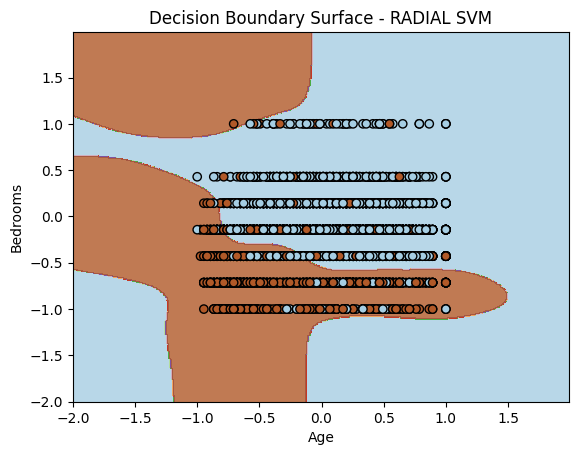

In [152]:
svc_best = SVC(kernel='rbf', C=tune_rbf.best_params_['C'],gamma = tune_rbf.best_params_['gamma'],cache_size=10000, random_state=42, max_iter=20000)

# fit the classifier to the training data
svc_best.fit(X_train, y_train)  # Update to use features 6 and 8

class_labels = ['Class 0', 'Class 1']
# define a grid of points
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
Z = svc_best.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# plot the decision boundary surface
# plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Paired, edgecolors='k')
plt.xlabel('Age')
plt.ylabel('Bedrooms')
# plt.legend(class_labels)
plt.title('Decision Boundary Surface - RADIAL SVM')
plt.show()

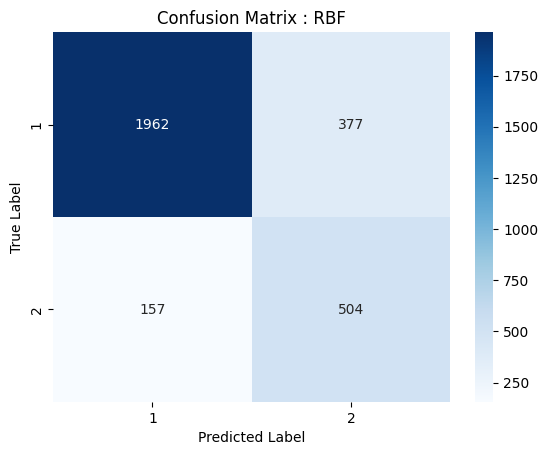

In [153]:
y_pred = tune_rbf.predict(X_test)

# create confusion matrix
conf_matrix = pd.crosstab(index=y_pred, columns=y_test, rownames=[''])

# create a heatmap of the confusion matrix
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d")

# add labels to the plot
plt.title("Confusion Matrix : RBF")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [154]:
# @title
print('Test Error',np.mean(y_pred != y_test))
print('Test Accuracy',np.mean(y_pred == y_test))

Test Error 0.178
Test Accuracy 0.822


In [155]:
# @title Polynomial
svcfit_poly = SVC(kernel = 'poly',cache_size = 10000,max_iter=15000, random_state = 1)
grid_params = {'C': [0.1,1,10],'gamma' : [2,4], 'degree' : [2,3,4]}
tune_poly = GridSearchCV(svcfit, grid_params ,cv=10)
tune_poly.fit(X_train,y_train)
print('COST: ',tune_poly.best_params_)
print('Least CV error rate: {:.2f}%'.format(1 - tune_poly.best_score_))
y_pred = tune_poly.predict(X_test)
print(classification_report(y_test,y_pred))

COST:  {'C': 10, 'degree': 2, 'gamma': 2}
Least CV error rate: 0.19%
              precision    recall  f1-score   support

           1       0.83      0.93      0.88      2119
           2       0.77      0.53      0.63       881

    accuracy                           0.82      3000
   macro avg       0.80      0.73      0.75      3000
weighted avg       0.81      0.82      0.80      3000



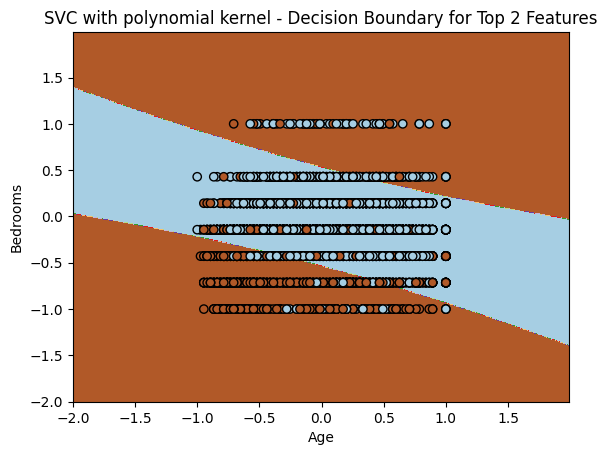

In [156]:
# @title
svc_best_poly = SVC(kernel='poly', C=tune_poly.best_params_['C'],gamma = tune_poly.best_params_['gamma'],degree = tune_poly.best_params_['degree'],cache_size=10000, random_state=1, max_iter=20000)
svc_best_poly.fit(X_train, y_train)

class_labels = ['Class 0', 'Class 1']

# define a grid of points
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
Z = svc_best_poly.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# plot the decision boundary surface
# plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Paired, edgecolors='k')
plt.xlabel('Age')
plt.ylabel('Bedrooms')  # Update the label to the actual feature name if known
plt.title('SVC with polynomial kernel - Decision Boundary for Top 2 Features')
plt.show()

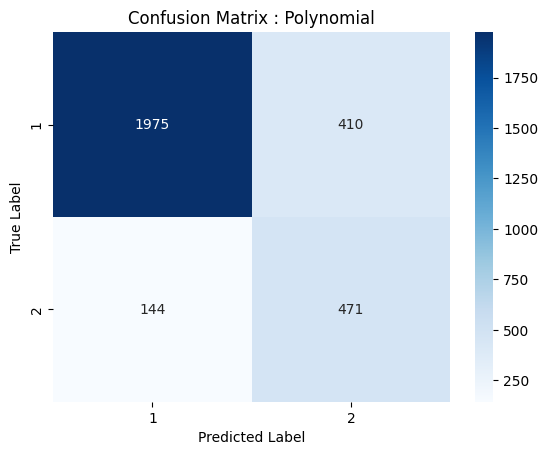

In [157]:
# @title
y_pred = tune_poly.predict(X_test)

# create confusion matrix
conf_matrix = pd.crosstab(index=y_pred, columns=y_test, rownames=[''])

# create a heatmap of the confusion matrix
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d")

# add labels to the plot
plt.title("Confusion Matrix : Polynomial")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [158]:
# @title
print('Test Error',np.mean(y_pred != y_test))
print('Test Accuracy',np.mean(y_pred == y_test))

Test Error 0.18466666666666667
Test Accuracy 0.8153333333333334


In [159]:
# @title